In [1]:
import pandas as pd
import numpy as np
import json


def get_options(df):
    # get the content of the options from the dataset
    opt_label = ['a', 'b', 'c', 'd', 'e']
    opts = list()
    for i in range(len(df)):
        options = df.iloc[i]['options']+" ,"
        answers = list()
        for label in opt_label:
            index_s = options.find(label+" ) ")+3
            index_len = options[index_s:].find(',')
            ans = options[index_s:index_s+index_len]
            answers.append(ans)
        opts.append(list(answers))
    opts = pd.DataFrame(opts, columns=['option_'+l for l in opt_label])
    return opts
    
def get_data(filepath):
    
    with open(filepath) as f:
        data = json.loads(f.read())
    
    df = pd.DataFrame(data)
    opts = get_options(df)
    new_data = df[['Problem', 'correct', 'category']].join(opts)
    return new_data


## 1. Get the dataset ##

In [2]:
filepath = 'dataset/MathQA/train.json'
train_df = get_data(filepath)
train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,a,gain,rs . 400,rs . 300,rs . 500,rs . 350,none of these
1,average age of students of an adult school is ...,d,general,1200,120,360,240,none of these
2,sophia finished 2 / 3 of a book . she calculat...,b,general,229,270,877,266,281
3,120 is what percent of 50 ?,b,gain,5 %,240 %,50 %,2 %,500 %
4,there are 10 girls and 20 boys in a classroom ...,a,other,1 / 2,1 / 3,1 / 5,10 / 30,2 / 5
...,...,...,...,...,...,...,...,...
29832,a man invests some money partly in 10 % stock ...,a,other,1 : 2,3 : 5,4 : 5,16 : 15,none
29833,"average of 10 matches is 32 , how many runs on...",d,general,a ) 70,b ) 76,c ) 78,d ) 98,e ) 88
29834,solve below question 2 x + 1 = - 23,c,general,- 8,- 9,- 12,- 4,12
29835,calculate 85184 ÷ ? = 352,b,general,241,242,244,247,240


## 2. Normalization

#### 1) normalizing functions: 30^10 2/3 10% 5:8

In [3]:
import re

# def remove_quotes(sen):
#     return sen[2:-2]

def add_space(sen):
    return " "+sen+" "

def replace_fraction(sen):
    # replace all string like "2 / 3 "
    pattern = re.compile(r'[0-9]+\s\/\s[0-9]+\s')    
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' / ')
            if int(nums[1]) != 0:
                new_results.append(str(int(nums[0])/int(nums[1]))[:8]+' ')
            else:
                new_results.append(str(np.NaN))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_percentage(sen):
    # replace all string like "20 %"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s%')   
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' ')
            new_results.append(str(round(float(nums[0])/100, 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_ratio(sen):
    # replace all string like " 2 : 3" "0.5 : 0.33 : 0.25"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s\:\s[0-9]+\.?[0-9]*')
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' : ')
            new_results.append(str(round(float(nums[0])/(float(nums[0])+float(nums[1])), 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_power(sen):
    # replace all string like "  30 ^ 10 "
    pass
    return sen

def replace_numword(sen):
    sen = sen.replace(' one ', ' 1 ')
    sen = sen.replace(' two ', ' 2 ')
    sen = sen.replace(' three ', ' 3 ')
    sen = sen.replace(' four ', ' 4 ')
    sen = sen.replace(' five ', ' 5 ')
    sen = sen.replace(' six ', ' 6 ')
    sen = sen.replace(' seven ', ' 7 ')
    sen = sen.replace(' eight ', ' 8 ')
    sen = sen.replace(' nine ', ' 9 ')
    sen = sen.replace(' ten ', ' 10 ')
    sen = sen.replace(' eleven ', ' 11 ')
    sen = sen.replace(' twelve ', ' 12 ')
    sen = sen.replace(' thirteen ', ' 13 ')
    sen = sen.replace(' fourteen ', ' 14 ')
    return sen

def replace_minus(sen):
    # replace all string like "- 20.5"
    pattern = re.compile(r'\-\s[0-9]+\.?[0-9]*')   
    results = pattern.findall(sen)
    
    if results != None:
        for i in results:
            sen = sen.replace(i, i.replace(" ", "", 1))
    return sen
    
def replace_punc(sen):
    # replace punctuation like "'" "." "|"
    sen = re.sub(r'\s[^\w\s]\s', ' ', sen)
    return sen


#### 2) normalise options

In [4]:
def answers_processing(answers):    
    # normalizing the correct answers
    # get the correct answers array that may contain NaN
    
    answers = answers.apply(replace_power)
    answers = answers.apply(replace_fraction)
    answers = answers.apply(replace_percentage)
    answers = answers.apply(replace_ratio)
    answers = answers.apply(replace_numword)
    answers = answers.apply(replace_minus)

    def separate_ans_numbers(sen):
        numbers = re.search(r'\-?[0-9]+\.?[0-9]*', sen)
        if numbers:
            numbers = numbers.group()
            return round(float(numbers), 4)
        else:
            return 
    answers = answers.apply(separate_ans_numbers)
    return answers

In [5]:
train_df[train_df.option_a.str.contains(' 5 / 0')]

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
4005,three 6 faced dice are thrown together . the p...,b,probability,5 / 0,5 / 9,5 / 1,5 / 3,5 / 6


In [6]:
# replace correct label
def num_label(s):
    if s == 'a':
        return 0
    elif s == 'b':
        return 1
    elif s == 'c':
        return 2
    elif s == 'd':
        return 3
    else:
        return 4
    
def sum_norm(train_df):
    norm_train_df = train_df.copy()
    # standardise all the options
    for i in range(5):
        norm_train_df.iloc[:, 3+i] = answers_processing(norm_train_df.iloc[:, 3+i])
    
    # normalise all the options
    option_df = pd.DataFrame(norm_train_df.iloc[:, 3:8])
    opt_sum = option_df.sum(axis=1)
    norm_train_df.iloc[:, 3:8] = option_df.div(opt_sum, axis=0)
        
    norm_train_df['correct'] = norm_train_df['correct'].apply(num_label)

    return norm_train_df
        

In [7]:
norm_train_df = sum_norm(train_df)
norm_train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29832,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29833,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29834,solve below question 2 x + 1 = - 23,2,general,0.380952,0.428571,0.571429,0.190476,-0.571429
29835,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


## 3. Get the content of correct answers from the options 

In [8]:
# get the subset that the correct answer is not NaN
ans = np.empty((norm_train_df.shape[0], 1))
for i in range(len(norm_train_df)):
    ans[i] = norm_train_df.iloc[i, 3+norm_train_df.iloc[i, 1]]

sub_train_df = norm_train_df[~np.isnan(ans)].reset_index(drop=True)
print(sub_train_df.shape)

ans_train = ans[~np.isnan(ans)]
print(ans_train.shape)

sub_train_df

(29669, 8)
(29669,)


,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29664,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29665,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29666,solve below question 2 x + 1 = - 23,2,general,0.380952,0.428571,0.571429,0.190476,-0.571429
29667,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


In [9]:
print(ans_train.shape)
ans_train

(29669,)


array([0.25806452, 0.125     , 0.14040562, ..., 0.57142857, 0.19934102,
       0.29268293])

## 4. Processing the problems and separate the text and numbers

#### 1) normalize the numbers and remove the punctuations

In [10]:
def problem_processing(problem):
    # processing the problems and normalize the numbers in the problem
    problem = problem.apply(add_space)
    problem = problem.apply(replace_power)
    problem = problem.apply(replace_fraction)
    problem = problem.apply(replace_percentage)
    problem = problem.apply(replace_ratio)
    problem = problem.apply(replace_numword)
    problem = problem.apply(replace_minus)
    problem = problem.apply(replace_punc)
    return problem

train_problems = problem_processing(sub_train_df['Problem'])

In [11]:
print(train_problems[28691])

 if the simple interest on a sum of money for 2 years at 0.05 per annum is rs 58 what is the compound interest on the same sum at the rate and for the same time 


#### 2) separate text and numbers in problems

In [12]:
def separate_numbers(sen):    
    pattarn = re.compile(r'\s\-?[0-9]+\.?[0-9]*\s')
    numbers = pattarn.findall(sen)
    numbers = np.array([round(float(i), 4) for i in numbers])
    return numbers
    
def separate_text(sen):
    pattarn = re.compile(r'\-?[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    for i in numbers:
        sen = sen.replace(" "+i+" ", " ")
    return sen    

text = train_problems.apply(separate_text)
print(text)

numbers = train_problems.apply(separate_numbers)
print(numbers)

0         the banker s gain of a certain sum due years ...
1         average age of students of an adult school is...
2         sophia finished of a book she calculated that...
3                                      is what percent of 
4         there are girls and boys in a classroom what ...
                               ...                        
29664     a man invests some money partly in stock at a...
29665     average of matches is how many runs should sh...
29666                              solve below question x 
29667                                         calculate ? 
29668     a vending machine is designed to dispense oun...
Name: Problem, Length: 29669, dtype: object
0                                         [3.0, 0.1, 36.0]
1                                 [40.0, 120.0, 32.0, 4.0]
2                                           [0.6667, 90.0]
3                                            [120.0, 50.0]
4                                             [10.0, 20.0]
            

## 4. Processing

### processing text ###

In [13]:
max_token = 0
for t in text:
    if len(t) > max_token:
        max_token = len(t)
print("the max tokens in the texts: ", max_token)

the max tokens in the texts:  745


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_features = 5000

# build a word vocab that contains top 5000 most frequent words
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(text)

print("token vocab length:", len(tok.word_index))
# print(tok.word_index)

x_train_seq = tok.texts_to_sequences(text)

# get the length and max length of text sequence in each sentence
seq_length = list()
max_seq = 0
for i in x_train_seq:
    seq_length.append(len(i))
max_seq = max(seq_length)
print("max sequence length: ", max_seq)


token vocab length: 8096
max sequence length:  136


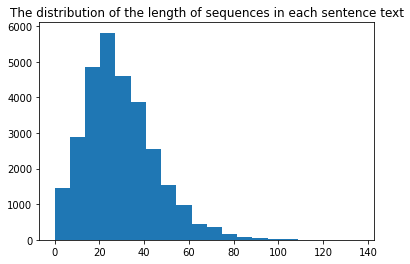

In [15]:
# get the distribution of the length of sequence in each sentence text
import matplotlib.pyplot as plt

plt.title("The distribution of the length of sequences in each sentence text")
plt.hist(seq_length, bins=20)
plt.xticks(np.arange(0, 150, 20))
plt.show()

In [16]:
# pad sequence (get the first 60/80 text sequence)
sequence_length = 60

# normalize the sequences
# x_train_norm = sum_norm(x_train_seq)

x_train= sequence.pad_sequences(x_train_seq, maxlen=sequence_length, truncating='post', padding='post')
x_train= x_train[:, :sequence_length]

print(x_train)
print(x_train.shape)
print(x_train.dtype)

[[   1 1351   40 ...    0    0    0]
 [  27  102    2 ...    0    0    0]
 [ 741    2    3 ...    0    0    0]
 ...
 [1108  704  621 ...    0    0    0]
 [ 601    0    0 ...    0    0    0]
 [   3  201    4 ...    2    1 1360]]
(29669, 60)
int32


### processing numbers ###

In [17]:
# the counts of the numbers in each sentence, get the distribution

max_number_seq = 0
num_seq_length = list()
for i in numbers:
    num_seq_length.append(len(i))
max_number_seq = max(num_seq_length)
print("max number sequence length: ", max_number_seq)


max number sequence length:  23


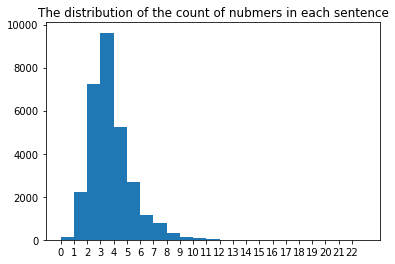

In [18]:
# get the distribution of the count of the nubmers
import matplotlib.pyplot as plt

plt.title("The distribution of the count of nubmers in each sentence")
plt.hist(num_seq_length, bins=max_number_seq)
plt.xticks(np.arange(max_number_seq))
plt.show()

In [19]:
# pad sequence (get the first 5 nubmers)
max_number_seq = 5
x_train_num = sequence.pad_sequences(numbers, dtype='float32', truncating='post', padding='post')
x_train_num = x_train_num[:, :max_number_seq]

print(x_train_num)
print(x_train_num.shape)
print(x_train_num.dtype)

[[3.0000e+00 1.0000e-01 3.6000e+01 0.0000e+00 0.0000e+00]
 [4.0000e+01 1.2000e+02 3.2000e+01 4.0000e+00 0.0000e+00]
 [6.6670e-01 9.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.5184e+04 3.5200e+02 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.5100e+00 7.8600e+00 8.0900e+00 8.3000e+00 7.7300e+00]]
(29669, 5)
float32


In [20]:
y_train = ans_train

## 5. Model

In [21]:
# Load Glove vectors

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_vec_file = 'dataset/glove.6B.300d.txt'
embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.076947  , -0.021211  ,  0.21270999, ...,  0.18351001,
        -0.29183   , -0.046533  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.36386001, -0.19165   ,  0.1198    , ..., -0.41835001,
         0.14703   , -0.21657   ],
       [-0.56441998, -0.056414  ,  0.28173   , ..., -0.28823999,
        -0.28601   , -0.13467   ]])

In [23]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)

8097
7572
0.9351611708040015


In [24]:
embedding_matrix.shape

(8097, 300)

### building model ###

In [25]:
LSTM_DIM = 16
DROPOUT = 0.1
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
HIDDEN_DIM = 8

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, Input
from keras.layers.merge import concatenate

def buildModel(vsize, input_dim, maxlen, emb_matrix, maxnumbers):

    text_input = Input(shape=(maxlen, ))     
    numerical_input = Input(shape=(maxnumbers, ))
    
    emb = Embedding(input_dim=vsize, 
                   output_dim=input_dim, 
                   weights=[emb_matrix],
                   trainable=False)(text_input)
    
    z = LSTM(LSTM_DIM)(emb)
    z = Dropout(DROPOUT)(z)
    z = Dense(HIDDEN_DIM, activation=ACTIVATION)(z)
    
    numerical_input = Input(shape=(maxnumbers, ))
    
    merged = concatenate([z, numerical_input])    
    predictions = Dense(1, activation='linear')(merged)
    
    model = Model([text_input, numerical_input], outputs=predictions)
    
    model.compile(optimizer=OPTIMIZER,
                  loss = LOSS,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, max_number_seq)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      2429100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 16)           20288       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [26]:
print(x_train.shape)
print(x_train_num.shape)
print(y_train.shape)

print(x_train[:5])
print(x_train_num[:5])
print(y_train[:5])

(29669, 60)
(29669, 5)
(29669,)
[[   1 1351   40  343    2    3   65   57  401   49  950   10   25  217
     4   22    8    4    1  251  434    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  27  102    2   80    2   38 2468  240    4   49  131   80  243   27
   102    4   49  734    1  240   45    3  445    1   27  102    4  406
    12   49   30    1   19    2   80    2    1  240   71 2281    2    1
   131   80    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 741    2    3  355  112  942   15  112  741   61  649   34  112   60
  4132    7  710   11   62    4  141  355    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   4    8   29    2    0    0    

In [27]:
EPOCHS = 1

model.fit(
    x=[x_train, x_train_num],
    y=y_train,
    batch_size=50,
    validation_split=0.1,
    epochs=EPOCHS,
)

535/535 [==============================] - 11s 18ms/step - loss: nan - rmse: nan - val_loss: nan - val_rmse: nan


In [31]:
y_train

array([0.25806452, 0.125     , 0.14040562, ..., 0.57142857, 0.19934102,
       0.29268293])